In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import analysis as readme

sns.set_style("white", {'ytick.major.size': 10.0})
sns.set_context("poster", font_scale=1.1)
matplotlib.rcParams.update({'font.size': 18, 'font.family': 'serif'})


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import json
from pprint import pprint
import random

## Design

The essesnce of XCMS is to assess the contact similarity between **different protein-ligand systems**.

Definitions:



1. **contact similarity**: spearmanr between the atom-residue distance vector when ligands and pockets are already aligned. Calculating spearmanr takes into account the vector length and yield p-value based on the length(sample size). The larger the sample size is, the more significant the correlation coefficient is.
2. **Protein global similarity**: Sequence identity
3. **Pocket similarity**: Apoc-score, significant if greater than 0.4
4. **Ligand similarity**: tanimoto coefficeint calculated by pkcombu, significant if greater than 0.5
5. **different protein-ligand systems**: protein sequence identity < 0.9 and ligand tc < 0.9


In [7]:
import biolip_query_biolip
import os
import luigi

In [9]:
from analysis import analysis, loadData, clean

## Load and Preprocessing

In [10]:
native_df, fixed_df, rnd_df = loadData()

loading random conformation querying biolip ...
loading native structures in biolip querying biolip ...
loading predicted structures in biolip querying biolip ...
merge to find shared queries and templates ...
sample 2000 queries
check consistency of ps_score and Tc


In [11]:
native_df.head()

,TM-score,Tc,num_binding_res,num_lig_atoms,ps_score,ps_score_pval,pval,query,rmsd,seq_identity,spearmanr,tc_times_ps,template
788843,0.99701,0.636364,14,7,0.85537,2.997000e-12,0.044649,187l_PXY_A_1.pdb,0.27,1.000,0.151993,0.544327,84/184l_I4B_A_1.pdb
788844,0.99758,0.777778,13,7,0.89914,1.981000e-12,0.000015,187l_PXY_A_1.pdb,0.24,1.000,0.340871,0.699331,88/188l_OXE_A_1.pdb
788845,0.22591,0.700000,5,7,0.30002,8.032000e-01,0.116979,187l_PXY_A_1.pdb,5.76,0.069,-0.199501,0.210014,a8/1a8u_BEZ_A_1.pdb
788846,0.20393,0.700000,10,7,0.31695,4.412000e-01,0.001752,187l_PXY_A_1.pdb,5.45,0.091,0.292480,0.221865,a8/1a8u_BEZ_B_1.pdb
788847,0.26116,0.700000,13,7,0.30788,5.157000e-01,0.029869,187l_PXY_A_1.pdb,5.07,0.083,0.183635,0.215516,ai/2aiq_BEN_A_1.pdb


In [12]:
native_df = readme.clean(native_df)
fixed_df = readme.clean(fixed_df)
rnd_df = readme.clean(rnd_df)

2000 queries and 814444 records in the original dataset
1996 queries and 753455 records after removing wield ps-score
1872 queries after filtering same systems
1871 queries after droping nan
2000 queries and 814444 records in the original dataset
1996 queries and 753455 records after removing wield ps-score
1872 queries after filtering same systems
1871 queries after droping nan
2000 queries and 814444 records in the original dataset
1996 queries and 753455 records after removing wield ps-score
1872 queries after filtering same systems
1871 queries after droping nan


In [13]:
fixed_df[(fixed_df.num_binding_res < 30) & (fixed_df.num_lig_atoms < 20)].sort_values(['num_binding_res', 'num_lig_atoms'], ascending=False).head()

,TM-score,Tc,num_binding_res,num_lig_atoms,ps_score,ps_score_pval,pval,query,rmsd,seq_identity,spearmanr,tc_times_ps,template
474193,0.72278,0.500000,29,19,0.68596,4.273000e-10,0.000000e+00,2j3l_P5A_A_1.pdb,2.91,0.184,0.973431,0.342980,gg/1ggm_GAP_A_1.pdb
474355,0.89639,0.463415,29,19,0.87041,2.998000e-15,0.000000e+00,2j3l_P5A_A_1.pdb,1.61,0.437,0.992575,0.403361,i4/2i4m_PSD_B_1.pdb
474374,0.67854,0.463415,29,19,0.73449,2.575000e-11,0.000000e+00,2j3l_P5A_A_1.pdb,2.72,0.198,0.988229,0.340374,ia/3ial_PR8_A_1.pdb
474518,0.27730,0.404255,29,19,0.31985,3.538000e-01,8.560131e-40,2j3l_P5A_A_1.pdb,7.20,0.094,0.434382,0.129301,kx/3kxw_1ZZ_A_1.pdb
474581,0.43241,0.452381,29,19,0.67469,5.455000e-10,0.000000e+00,2j3l_P5A_A_1.pdb,5.08,0.117,0.979502,0.305217,m4/3m4p_4AD_C_1.pdb


## Plot
### Heatmap

In [14]:
import re
def normalizeRanges(s):
    lo, hi = re.findall(r'[+-]?\d+\.*\d*', s)
    return "(%.3f, %.3f]" % (float(lo), float(hi))

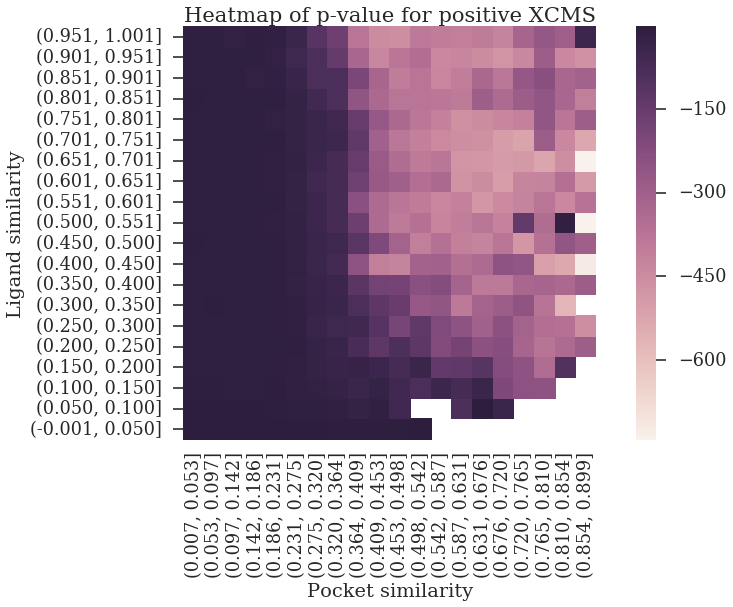

In [15]:
df = native_df
df = df[(df.pval > 0) & (df.spearmanr > 0)]

data = df.groupby([pd.cut(df['Tc'], 20), pd.cut(df['ps_score'], 20)])['pval'].apply(
    lambda pvals: np.mean(np.log(pvals))).unstack()
data = data.reindex(index=data.index[::-1])
sns.heatmap(data, square=True, 
            xticklabels=map(normalizeRanges, data.index[::-1]), 
            yticklabels=map(normalizeRanges, data.columns[::-1]))
plt.title("Heatmap of p-value for positive XCMS")
plt.xlabel("Pocket similarity")
plt.ylabel("Ligand similarity")
plt.tight_layout()
plt.savefig("/work/jaydy/working/p_val.tiff", dpi=200)

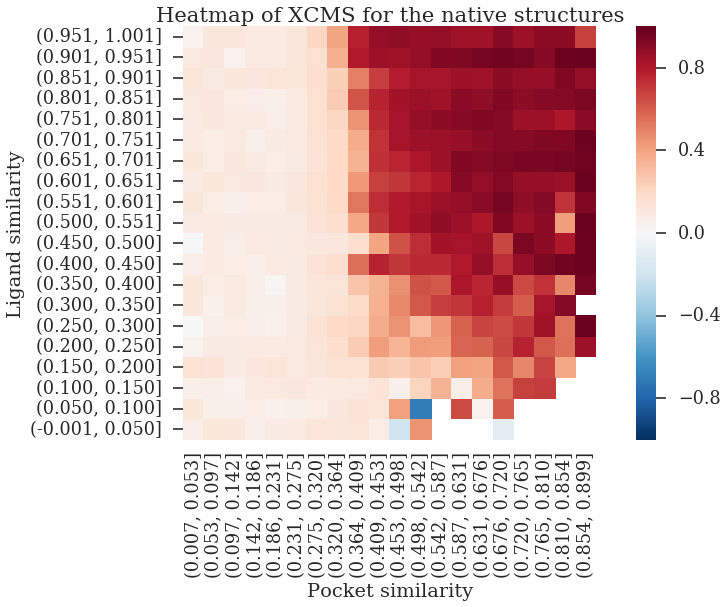

In [16]:
df = native_df
data = df.groupby([pd.cut(df['Tc'], 20), pd.cut(df['ps_score'], 20)])['spearmanr'].mean().unstack()
data = data.reindex(index=data.index[::-1])
sns.heatmap(data, square=True, 
            xticklabels=map(normalizeRanges, data.index[::-1]), 
            yticklabels=map(normalizeRanges, data.columns[::-1]),
            vmin=-1, 
            vmax=1
           )
plt.title("Heatmap of XCMS for the native structures")
plt.xlabel("Pocket similarity")
plt.ylabel("Ligand similarity")
plt.tight_layout()
plt.savefig("/work/jaydy/working/native_xcms.tiff", dpi=200)

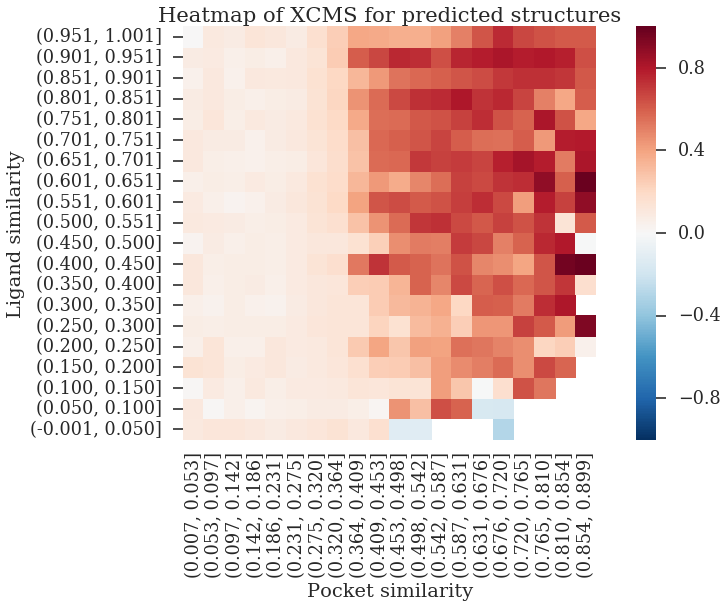

In [17]:
df = fixed_df
data = df.groupby([pd.cut(df['Tc'], 20), pd.cut(df['ps_score'], 20)])['spearmanr'].mean().unstack()
data = data.reindex(index=data.index[::-1])
sns.heatmap(data, square=True, 
            xticklabels=map(normalizeRanges, data.index[::-1]), 
            yticklabels=map(normalizeRanges, data.columns[::-1]),
            vmin=-1, 
            vmax=1
           )
plt.title("Heatmap of XCMS for predicted structures")
plt.xlabel("Pocket similarity")
plt.ylabel("Ligand similarity")
plt.tight_layout()
plt.savefig("/work/jaydy/working/predicted_xcms.tiff", dpi=200)

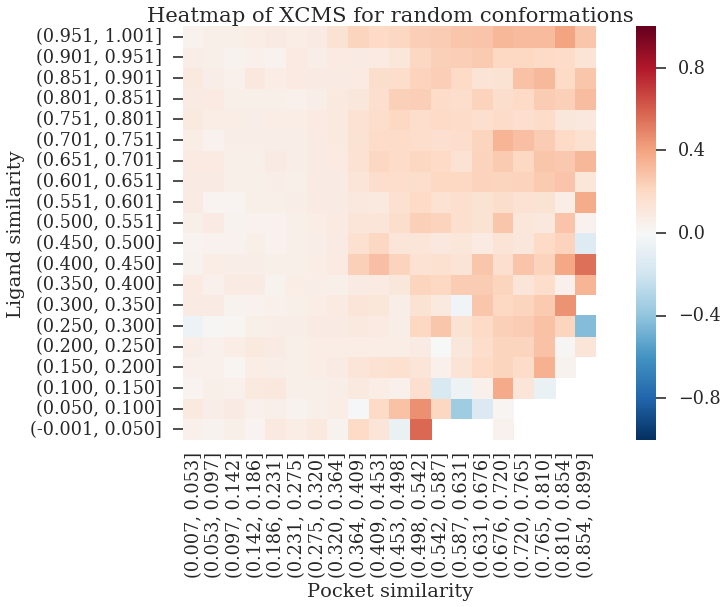

In [18]:
df = rnd_df
data = df.groupby([pd.cut(df['Tc'], 20), pd.cut(df['ps_score'], 20)])['spearmanr'].mean().unstack()
data = data.reindex(index=data.index[::-1])
sns.heatmap(data, square=True, 
            xticklabels=map(normalizeRanges, data.index[::-1]), 
            yticklabels=map(normalizeRanges, data.columns[::-1]),
            vmin=-1, 
            vmax=1)
plt.title("Heatmap of XCMS for random conformations")
plt.xlabel("Pocket similarity")
plt.ylabel("Ligand similarity")
plt.tight_layout()
plt.savefig("/work/jaydy/working/random_xcms.tiff", dpi=200)

## Distribution of RMSD

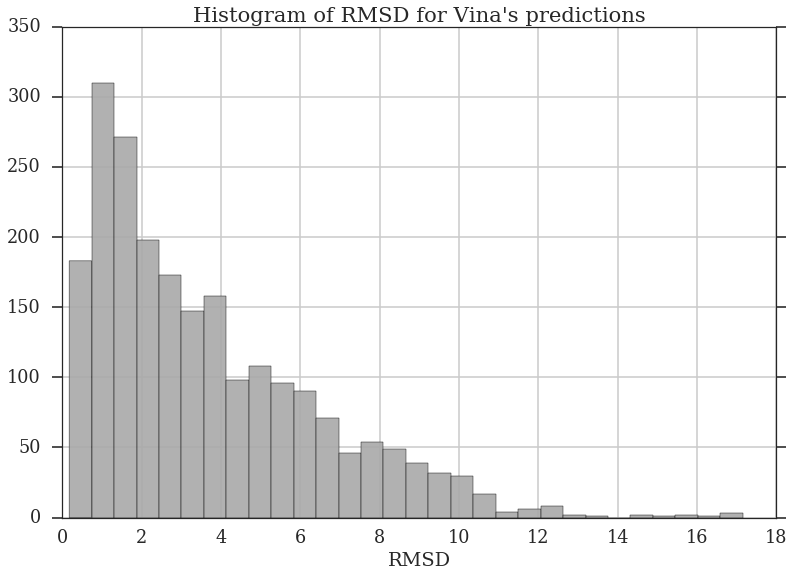

In [19]:
predicted_rmsd = pd.read_csv(readme.CheckVinaResultAccuracy().output().path, index_col=0)

predicted_rmsd.rmsd.hist(bins=30, color='darkgrey', alpha=0.9)
plt.title("Histogram of RMSD for Vina's predictions")
plt.xlabel("RMSD")
plt.savefig("/work/jaydy/working/predict_rmsd_hist.tiff", dpi=200)

## Distribution of CMS

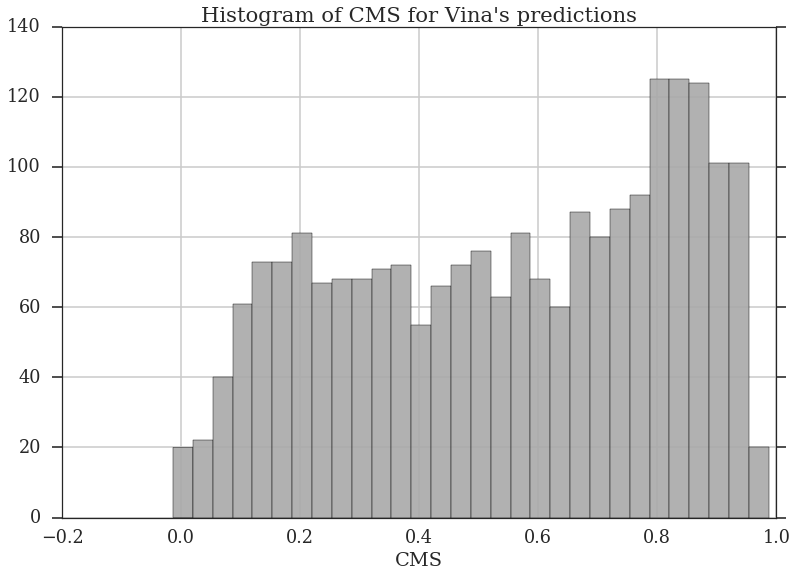

In [20]:
predicted_rmsd.cms.hist(bins=30, color='darkgrey', alpha=0.9)
plt.title("Histogram of CMS for Vina's predictions")
plt.xlabel("CMS")
plt.savefig("/work/jaydy/working/predict_rcms_hist.tiff", dpi=200)

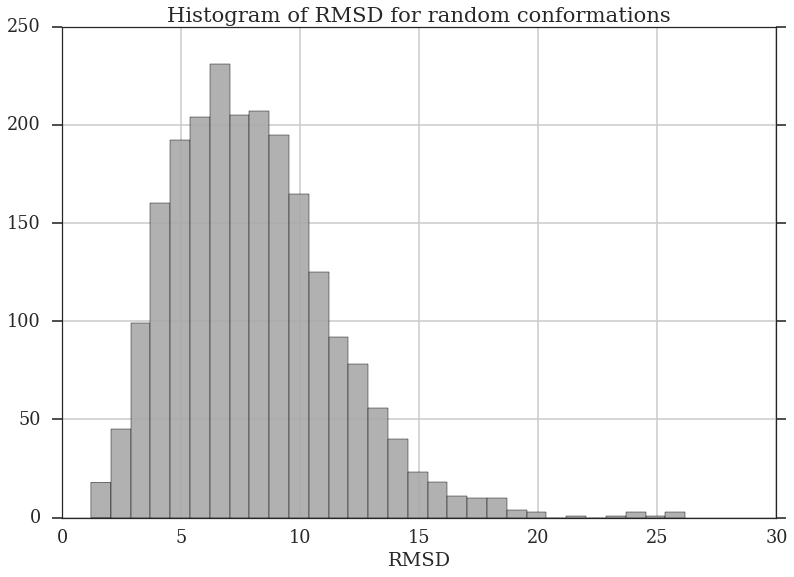

In [21]:
rnd_rmsd = pd.read_csv(readme.CheckVinaRandomRmsd().output().path, index_col=0)

rnd_rmsd.rmsd.hist(bins=30, color='darkgrey', alpha=0.9)
plt.title("Histogram of RMSD for random conformations")
plt.xlabel("RMSD")
plt.savefig("/work/jaydy/working/random_rmsd_hist.tiff", dpi=200)

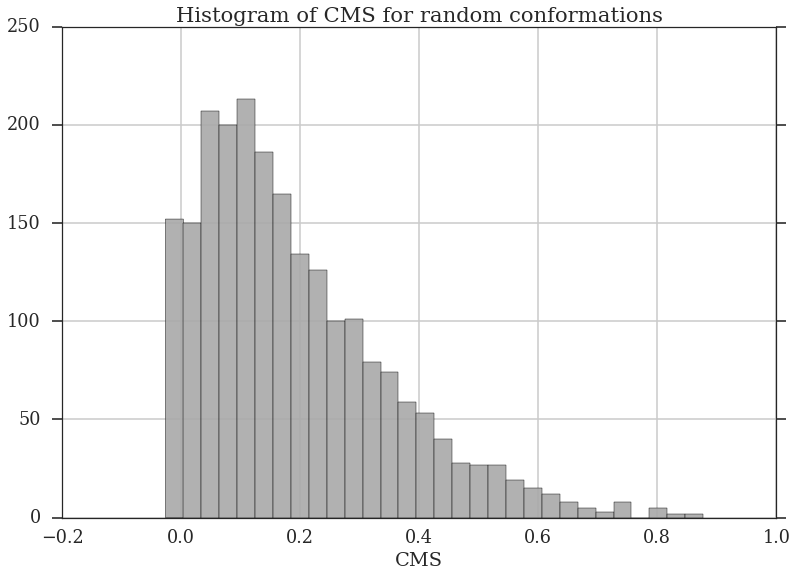

In [22]:
rnd_rmsd.cms.hist(bins=30, color='darkgrey', alpha=0.9)
plt.title("Histogram of CMS for random conformations")
plt.xlabel("CMS")
plt.savefig("/work/jaydy/working/random_cms_hist.tiff", dpi=200)

## Filter by similar pockets and ligands 

In [23]:
native_df = readme.similarPocketsLigands(native_df)
fixed_df = readme.similarPocketsLigands(fixed_df)
rnd_df = readme.similarPocketsLigands(rnd_df)

716 queries after filtering dissimilar pockets and ligands
38.268% survive
723 queries after filtering dissimilar pockets and ligands
38.642% survive
723 queries after filtering dissimilar pockets and ligands
38.642% survive


## Rank by similarity of pockets and ligands

    - Each query may have multiple templates

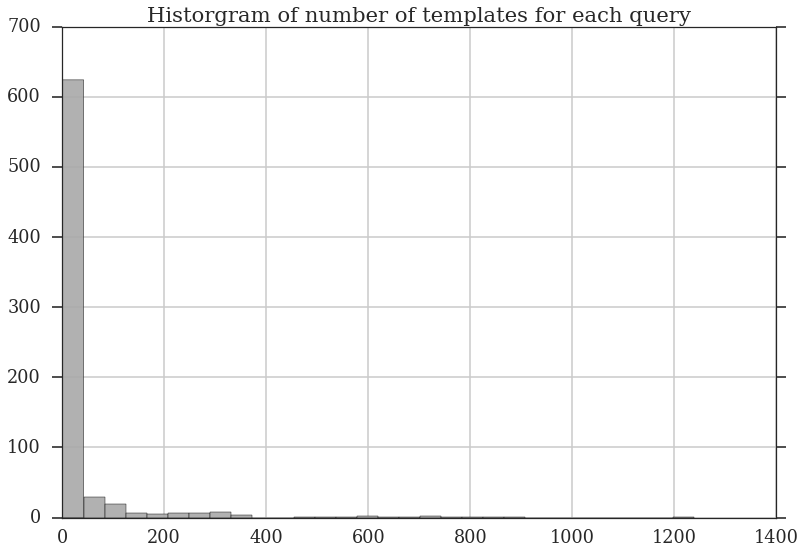

In [24]:
fixed_df.groupby("query").apply(lambda g: g.shape[0]).hist(bins=30, color='darkgrey', alpha=0.9)
plt.title("Historgram of number of templates for each query")

    - Rank each query's templates by Tc times ps-score

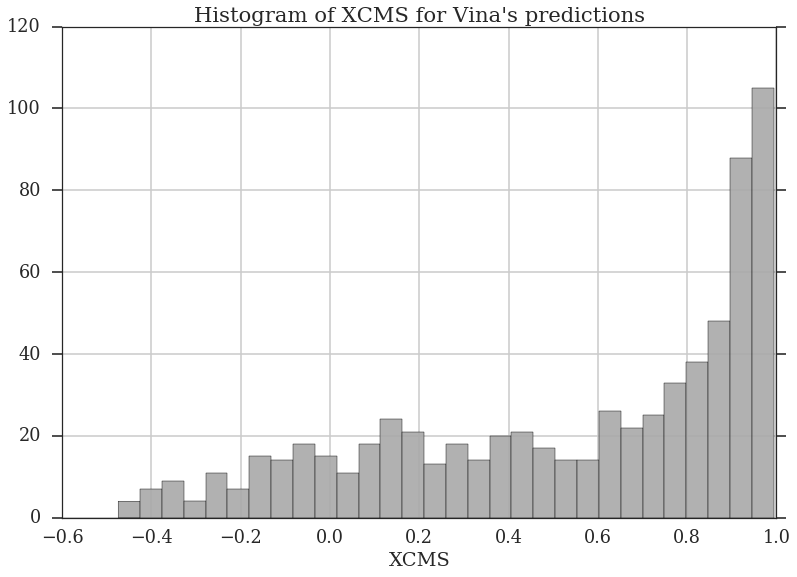

In [25]:
fiexed_xcms = fixed_df[["query", "spearmanr", "pval", "tc_times_ps", "TM-score", "template"]]

fixed_rmsd_xcms = pd.merge(fiexed_xcms, predicted_rmsd)

fixed_spearmanr = fixed_rmsd_xcms.groupby("query").apply(
    lambda g: g.sort_values("tc_times_ps", ascending=False).iloc[0][["spearmanr", "rmsd", "TM-score", "cms"]])

fixed_spearmanr.spearmanr.hist(bins=30, color='darkgrey', alpha=0.9)
plt.title("Histogram of XCMS for Vina's predictions")
plt.xlabel("XCMS")
plt.savefig("/work/jaydy/working/predict_xcms_hist.tiff", dpi=200)

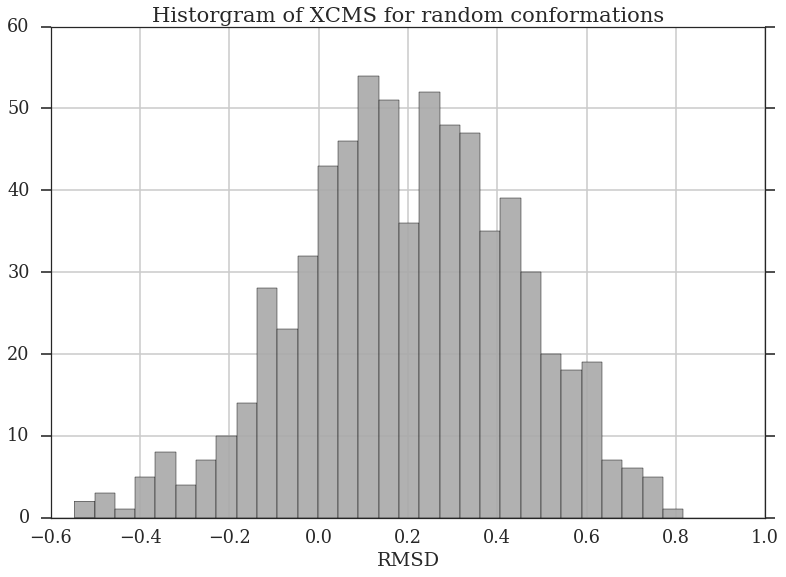

In [26]:
rnd_xcms = rnd_df[["query", "spearmanr", "pval", "tc_times_ps", "TM-score", "template"]]

rnd_rmsd_xcms = pd.merge(rnd_xcms, rnd_rmsd)

rnd_spearmanr = rnd_rmsd_xcms.groupby("query").apply(
    lambda g: g.sort_values("tc_times_ps", ascending=False).iloc[0][["spearmanr", "rmsd", "cms"]])

rnd_spearmanr.spearmanr.hist(bins=30, color='darkgrey', alpha=0.9)
plt.title("Historgram of XCMS for random conformations")
plt.xlabel("RMSD")
plt.savefig("/work/jaydy/working/random_xcms_hist.tiff", dpi=200)

## Correlation between CMS and RMSD

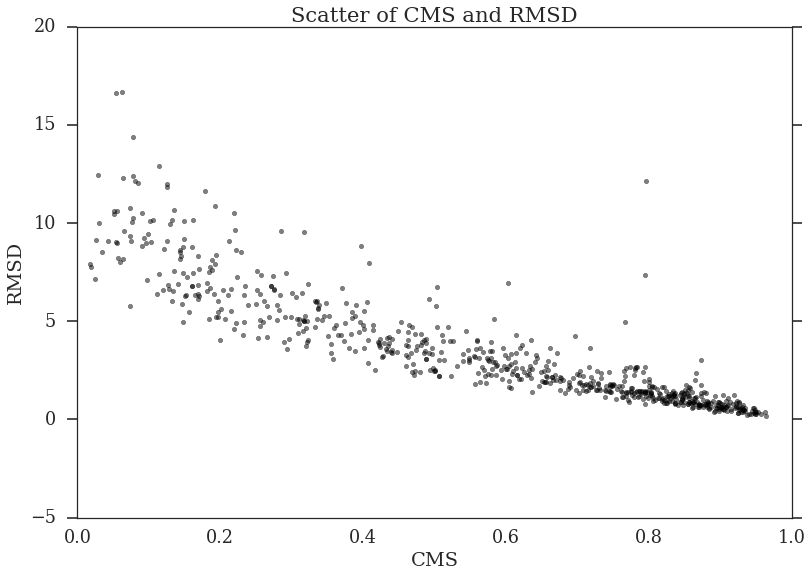

In [27]:
fixed_spearmanr.plot(kind="scatter", x='cms', y='rmsd', color='k', alpha=0.5)
plt.xlabel("CMS")
plt.ylabel("RMSD")
plt.xlim((0, 1))
plt.title("Scatter of CMS and RMSD")
# plt.ylim((-0.6, 1))
plt.savefig("/work/jaydy/working/cms_rmsd_scatter.tiff", dpi=200)

## Split based on the global similarity, with threshold TM-score = 0.5

In [28]:
high_tm = fixed_spearmanr[fixed_spearmanr["TM-score"] > 0.5]
low_tm = fixed_spearmanr[fixed_spearmanr["TM-score"] < 0.5]

## Correlation between XCMS and CMS

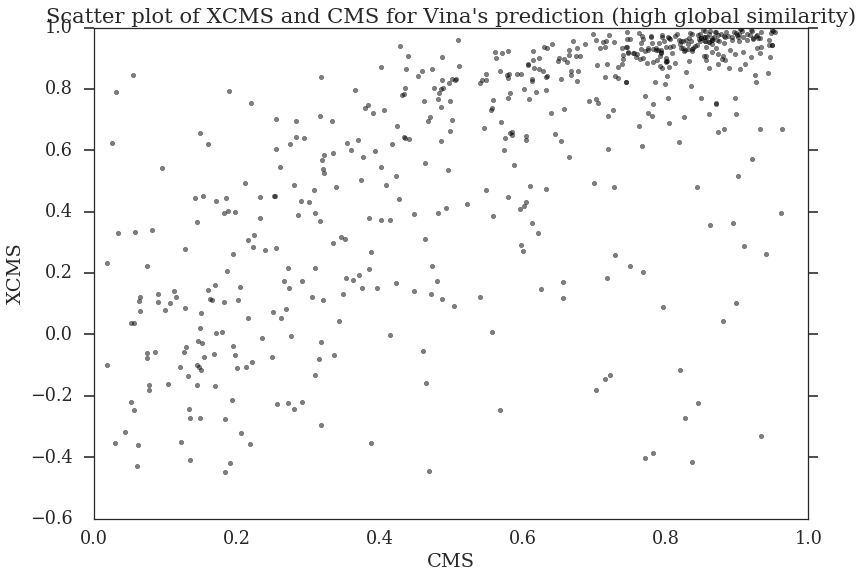

In [29]:
high_tm.plot(kind="scatter", x="cms", y="spearmanr", color='k', alpha=0.5)
plt.title("Scatter plot of XCMS and CMS for Vina's prediction (high global similarity)")
plt.xlim((0, 1))
plt.ylim((-0.6, 1))
plt.xlabel("CMS")
plt.ylabel("XCMS")
plt.savefig("/work/jaydy/working/cms_xcms_high_scatter.tiff", dpi=200)

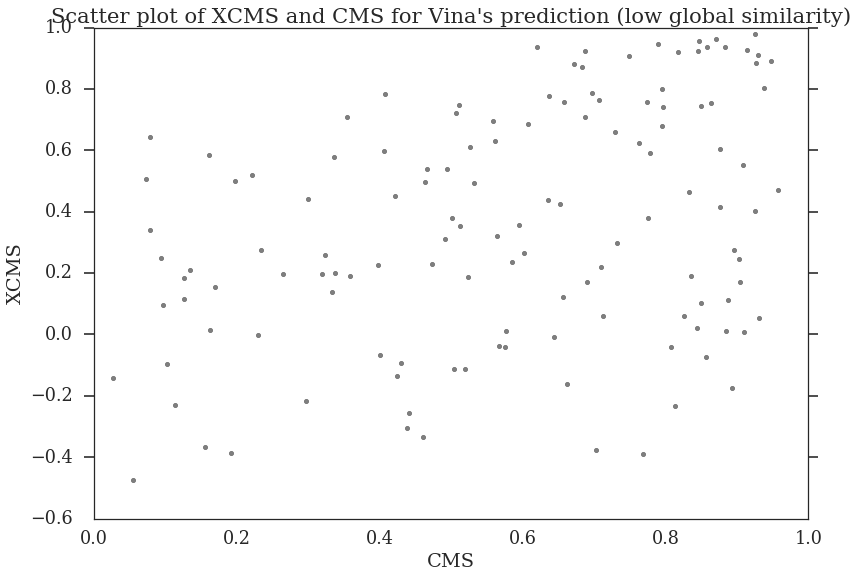

In [30]:
low_tm.plot(kind="scatter", x="cms", y="spearmanr", color='k', alpha=0.5)
plt.title("Scatter plot of XCMS and CMS for Vina's prediction (low global similarity)")
plt.xlim((0, 1))
plt.ylim((-0.6, 1))
plt.xlabel("CMS")
plt.ylabel("XCMS")
plt.savefig("/work/jaydy/working/cms_xcms_low_scatter.tiff", dpi=200)

## Correlation between XCMS and RMSD

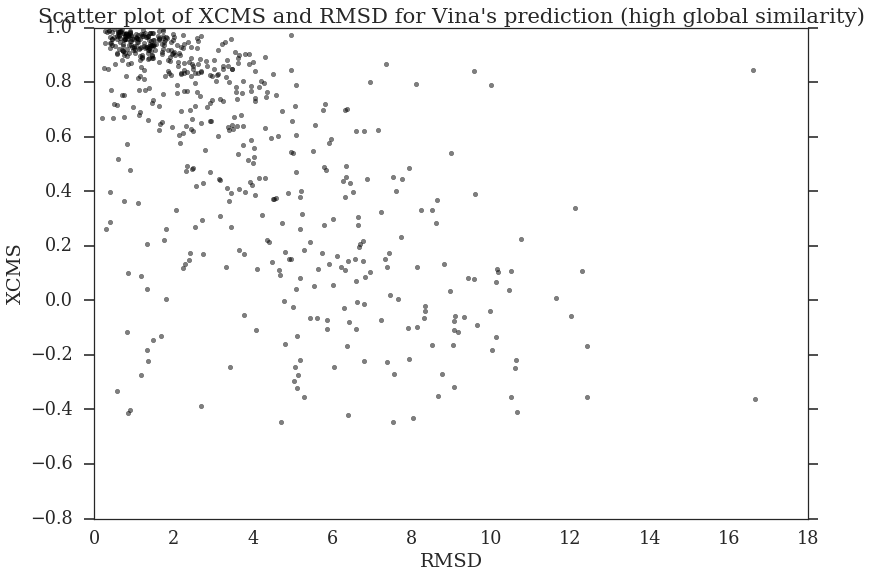

In [31]:
high_tm.plot(kind="scatter", x="rmsd", y="spearmanr", color='k', alpha=0.5)
plt.title("Scatter plot of XCMS and RMSD for Vina's prediction (high global similarity)")
plt.xlim((0, 18))
plt.ylim((-0.8, 1))
plt.xlabel("RMSD")
plt.ylabel("XCMS")
plt.savefig("/work/jaydy/working/rmsd_xcms_high_scatter.tiff", dpi=200)

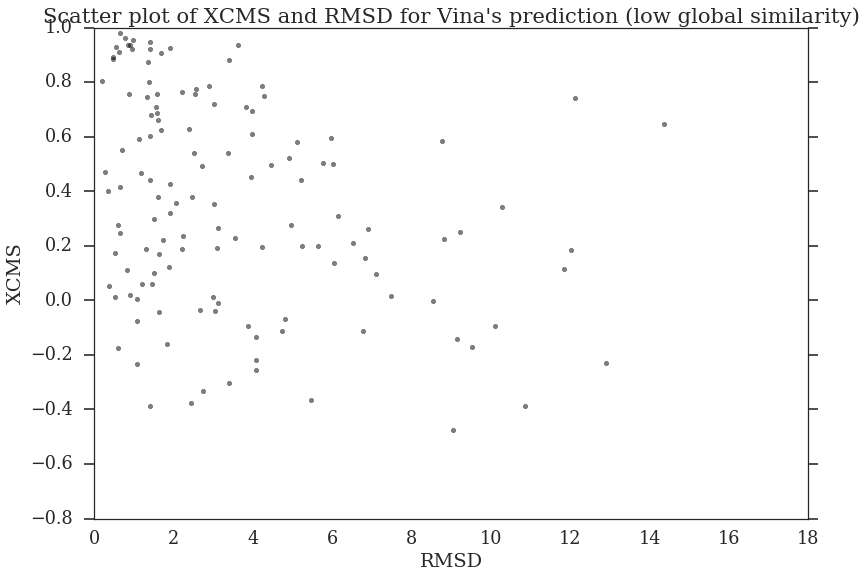

In [32]:
low_tm.plot(kind="scatter", x="rmsd", y="spearmanr", color='k', alpha=0.5)
plt.title("Scatter plot of XCMS and RMSD for Vina's prediction (low global similarity)")
plt.xlim((0, 18))
plt.ylim((-0.8, 1))
plt.xlabel("RMSD")
plt.ylabel("XCMS")
plt.savefig("/work/jaydy/working/rmsd_xcms_low_scatter.tiff", dpi=200)

## Case study example

In [33]:
low_tm[(low_tm['TM-score'] > 0.2) & (low_tm['rmsd'] < 2) &
       (low_tm['spearmanr'] > 0.6)]

,spearmanr,rmsd,TM-score,cms
query,,,,
1a69_FMB_C_1.pdb,0.947683,1.398875,0.46580,0.789529
1d1q_4NP_A_1.pdb,0.892066,0.471212,0.31897,0.948201
1d5j_MM3_B_1.pdb,0.872142,1.359336,0.45246,0.682835
1g4p_FQP_A_1.pdb,0.922353,1.398788,0.39111,0.845892
1i36_NAP_A_1.pdb,0.962254,0.770128,0.45096,0.870373
1i36_NAP_B_1.pdb,0.955098,0.974107,0.44752,0.847024
1o8b_ABF_A_1.pdb,0.756368,1.581726,0.26849,0.774737
1qf1_TI1_A_1.pdb,0.911588,0.627540,0.21886,0.929861
2ag0_TPP_A_1.pdb,0.907401,1.691267,0.20636,0.749124


In [46]:
high_tm[high_tm.rmsd < 2].ix['2yiw_YIW_A_1.pdb']

KeyError: '2yiw_YIW_A_1.pdb'

In [34]:
low_tm.ix[['1a69_FMB_C_1.pdb']]

,spearmanr,rmsd,TM-score,cms
query,,,,
1a69_FMB_C_1.pdb,0.947683,1.398875,0.4658,0.789529


In [35]:
low_tm.ix[['3pd3_A3T_A_1.pdb']]

,spearmanr,rmsd,TM-score,cms
query,,,,
3pd3_A3T_A_1.pdb,0.798854,1.388295,0.21101,0.795164


In [36]:
from sklearn import metrics
high_tm['native_like'] = high_tm.rmsd.apply(lambda r: 1 if r < 3 else 0)
low_tm['native_like'] = low_tm.rmsd.apply(lambda r: 1 if r < 3 else 0)
hfpr, htpr, hthresholds = metrics.roc_curve(high_tm.native_like, high_tm.spearmanr, pos_label=1)
lfpr, ltpr, lthresholds = metrics.roc_curve(low_tm.native_like, low_tm.spearmanr, pos_label=1)

/ddnB/work/jaydy/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/ddnB/work/jaydy/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


High global similarity AUC: 0.866981
Low global similarity AUC: 0.656353


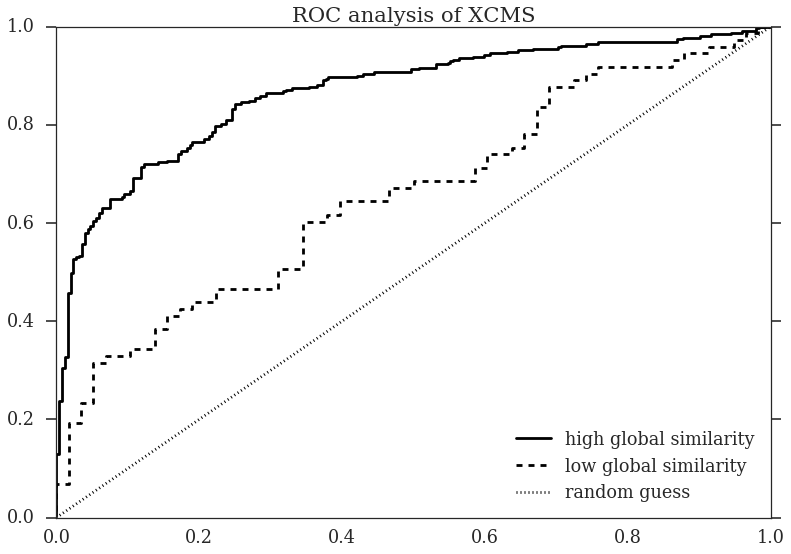

In [37]:
plt.plot(hfpr, htpr, 'k-', label="high global similarity")
plt.plot(lfpr, ltpr, 'k--', label="low global similarity")
plt.plot([0,1], [0, 1], 'k:', label="random guess")
plt.legend(loc='lower right')

plt.title("ROC analysis of XCMS")
print("High global similarity AUC: %f" % metrics.auc(hfpr, htpr))
print("Low global similarity AUC: %f" % metrics.auc(lfpr, ltpr))
plt.savefig("/work/jaydy/working/xcms_roc.tiff", dpi=200)

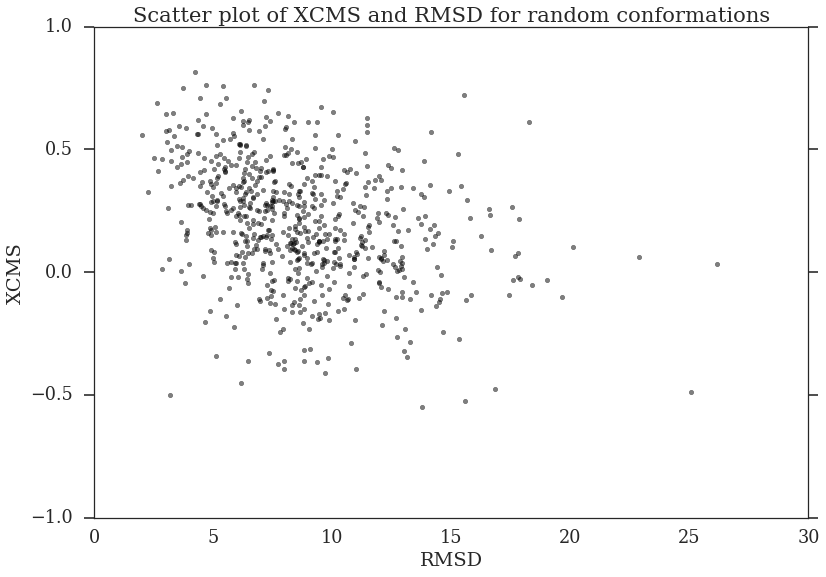

In [38]:
rnd_spearmanr.plot(kind="scatter", x="rmsd", y="spearmanr", color='k', alpha=0.5)
plt.title("Scatter plot of XCMS and RMSD for random conformations")
plt.xlim((0, 30))
plt.ylim((-1, 1))
plt.xlabel("RMSD")
plt.ylabel("XCMS")

## Back Compatibility from XCMS to CMS

In [39]:
xcms_back_df = pd.read_csv(readme.CheckVinaResultAgainstIdenticalSystems().output().path, index_col=0)

In [40]:
xcms_back_df['query'] = xcms_back_df.index.values

In [41]:
predicted_rmsd.head()

,cms,fraction,query,rmsd
0,0.358803,0.857143,2uud_PHX_J_1.pdb,4.105002
1,0.419786,0.222222,2wh5_COA_E_1.pdb,5.648441
2,0.399885,0.840909,2ed3_SAH_A_1.pdb,4.804509
3,0.602438,0.952381,4b2i_LZ1_A_1.pdb,1.966859
4,0.665037,0.890909,2zzu_359_H_1.pdb,1.850015


In [42]:
predicted_df = pd.merge(predicted_rmsd, xcms_back_df[['query', 'spearmanr']])

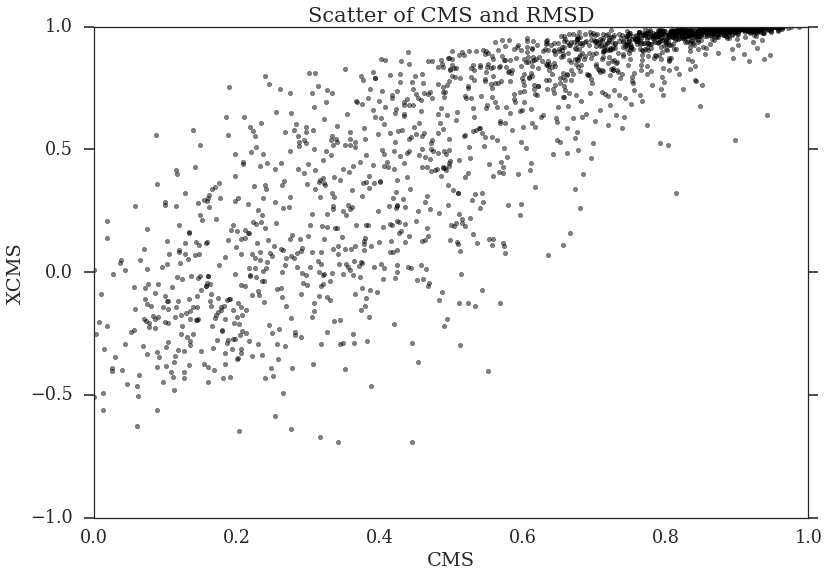

In [43]:
predicted_df.plot(kind='scatter', x='cms', y='spearmanr', color='k', alpha=0.5)
plt.xlabel('CMS')
plt.ylabel("XCMS")
plt.xlim((0, 1))
plt.ylim((-1, 1))
plt.title("Scatter of CMS and RMSD")
plt.savefig("/work/jaydy/working/cms_xcms_scatter.tiff", dpi=200)